In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import torch
import torch.nn.functional as F

# Next step: Use Scipy.minimize(method="BFGS"), use Eric's jac trick

torch.set_default_dtype(torch.float64)

def g(X,Y):
    return torch.sin(np.pi*X)*torch.sin(np.pi*Y)

def f(X,Y):
    return -2*torch.pi**2*g(X,Y)


n_grids = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150]
#n_grids = [5]

errors = []
errors_test = []

ii = 0

for n_grid in n_grids:
    print("n_grid={}".format(n_grid))
    #n_grid = 400


    x = torch.linspace(-1,1,steps=n_grid)
    y = torch.linspace(-1,1,steps=n_grid)
    x_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    y_test = torch.linspace(-1,1,steps=2*n_grid-1)[1:-1:2]
    X, Y = torch.meshgrid(x, y)
    h = 2/(n_grid-1)
    
    # free parameters have size (n_grid-2)*(n_grid-2)
    def free2full(free):
        shape = free.shape
        full = torch.zeros(shape[0]+2, shape[1]+2)
        full[1:-1,1:-1] = free
        return full
    
    def full2free(full):
        return full[1:-1,1:-1]

    # PDE 
    def Laplacian(full, h):
        Lapx = (full[2:,1:-1] + full[:-2,1:-1] - 2*full[1:-1,1:-1])/h**2
        Lapy = (full[1:-1,2:] + full[1:-1,:-2] - 2*full[1:-1,1:-1])/h**2
        Lap = Lapx + Lapy
        return Lap

    def Lap_loss(full, h, x, y):
        Lap_numerical = Laplacian(full,h)
        X, Y = torch.meshgrid(x[1:-1],y[1:-1])
        Lap_true = f(X,Y)
        #plt.matshow(Lap_numerical.detach().numpy())
        #plt.colorbar()
        #plt.matshow(Lap_true.detach().numpy())
        #plt.colorbar()
        return torch.mean((Lap_numerical-Lap_true)**2)

    # initalize z as random parameters, note sequential training
    #z = g(X,Y)
    if ii == 0:
    #if True:
        z = torch.normal(0,1,size=(n_grid-2,n_grid-2))*0.001
        z_full = free2full(z)
        #z_full = torch.sin(np.pi*X)*torch.sin(np.pi*Y)
        z = torch.nn.Parameter(z, requires_grad=True)
    else:
        # interpolate from last result
        full = free2full(z)
        full = F.interpolate(full.unsqueeze(dim=0).unsqueeze(dim=0), size=(n_grid,n_grid), mode='bilinear', align_corners=True)[0,0]
        z = full2free(full)
        z = torch.nn.Parameter(z, requires_grad=True)
        
    ii = ii + 1
    
    # initialize adam (learning rate scaling lr~h**4), z as parameters
    lr = 1e-2*(10/n_grid)**3
    opt = torch.optim.Adam({z}, lr=lr, eps=1e-8)
    #opt = torch.optim.SGD({z}, lr=lr)
    
    # iterations here (learning rate decay)
    epochs = 15000
    switch_epoch = 3000
    log = 100
    best_loss = 1e20
    losses = []
    
    for i in range(epochs):
        if (i+1) % switch_epoch == 0:
            for opt_param in opt.param_groups:
                lr = lr * 0.5
                opt_param['lr'] = lr
        
        def loss_closure():
            opt.zero_grad()
            z_full = free2full(z)
            loss_train = Lap_loss(z_full, h, x, y)
            z_interp = F.interpolate(z_full.unsqueeze(dim=0).unsqueeze(dim=0), size=(2*n_grid-1,2*n_grid-1), mode='bilinear', align_corners=True)[0,0]
            z_test = z_interp[1:-1:2,1:-1:2]
            loss_test = Lap_loss(z_test, h, x_test, y_test)
            loss = (loss_test*(n_grid-3)**2 + loss_train*(n_grid-2)**2)/((n_grid-3)**2+(n_grid-2)**2)
            loss.backward()
            return loss
          # -------------------------------------------
        loss = loss_closure()
        opt.step(loss_closure)  # get loss, use to update wts
        if loss < best_loss:
            best_loss = loss
            best_epoch = i
            best_z = z.clone()
        if i % log == 0:
            print("Epoch: {}".format(i) + " | " + "Loss: {}".format(loss.detach().numpy()))
        losses.append(loss.detach().numpy())
    
    errors.append(best_loss.detach().numpy())
    
    torch.save(z, './poisson_results/z_n_{}'.format(n_grid))
    torch.save(best_loss, './poisson_results/loss_n_{}'.format(n_grid))


n_grid=10
Epoch: 0 | Loss: 132.7088605651295
Epoch: 100 | Loss: 5.403291894309068
Epoch: 200 | Loss: 0.5120313622622963
Epoch: 300 | Loss: 0.5000635729980092
Epoch: 400 | Loss: 0.5000619785822065
Epoch: 500 | Loss: 0.5000615449872875
Epoch: 600 | Loss: 0.5000614463838791
Epoch: 700 | Loss: 0.5000614287858722
Epoch: 800 | Loss: 0.5000707614140383
Epoch: 900 | Loss: 0.500061426326795
Epoch: 1000 | Loss: 0.5000614262650733
Epoch: 1100 | Loss: 0.5000645761902321
Epoch: 1200 | Loss: 0.5000921487521873
Epoch: 1300 | Loss: 0.5002341044612109
Epoch: 1400 | Loss: 0.5004125135498717
Epoch: 1500 | Loss: 0.5000618087940502
Epoch: 1600 | Loss: 0.5000656469337035
Epoch: 1700 | Loss: 0.5000617970937168
Epoch: 1800 | Loss: 0.5000624387449357
Epoch: 1900 | Loss: 0.5000616466033582
Epoch: 2000 | Loss: 0.5000614828522809
Epoch: 2100 | Loss: 0.5000614262802247
Epoch: 2200 | Loss: 0.5000824829276748
Epoch: 2300 | Loss: 0.500061447194089
Epoch: 2400 | Loss: 0.5000614260288779
Epoch: 2500 | Loss: 0.500157816

Epoch: 6000 | Loss: 0.07717450452417239
Epoch: 6100 | Loss: 0.07717450112804884
Epoch: 6200 | Loss: 0.07717450112776277
Epoch: 6300 | Loss: 0.07717450112776301
Epoch: 6400 | Loss: 0.07717450112776272
Epoch: 6500 | Loss: 0.07717450112776283
Epoch: 6600 | Loss: 0.07717450112776304
Epoch: 6700 | Loss: 0.0771745011277627
Epoch: 6800 | Loss: 0.07717450112776282
Epoch: 6900 | Loss: 0.07717450112776252
Epoch: 7000 | Loss: 0.07717450112776295
Epoch: 7100 | Loss: 0.0771745011277632
Epoch: 7200 | Loss: 0.07717450112776324
Epoch: 7300 | Loss: 0.07717450112776297
Epoch: 7400 | Loss: 0.07717450112776318
Epoch: 7500 | Loss: 0.077174501127763
Epoch: 7600 | Loss: 0.07717450112776303
Epoch: 7700 | Loss: 0.07719025306011827
Epoch: 7800 | Loss: 0.07717450172856231
Epoch: 7900 | Loss: 0.07717450112778326
Epoch: 8000 | Loss: 0.07717450112776295
Epoch: 8100 | Loss: 0.07717450112776282
Epoch: 8200 | Loss: 0.07779068698989604
Epoch: 8300 | Loss: 0.07717451664025814
Epoch: 8400 | Loss: 0.07717450112811913
Epoc

Epoch: 11200 | Loss: 0.02147706098155847
Epoch: 11300 | Loss: 0.021477060981540175
Epoch: 11400 | Loss: 0.021477061100695135
Epoch: 11500 | Loss: 0.021477128304142442
Epoch: 11600 | Loss: 0.021477060983380303
Epoch: 11700 | Loss: 0.02147706098154008
Epoch: 11800 | Loss: 0.02147720202627728
Epoch: 11900 | Loss: 0.021477075478489115
Epoch: 12000 | Loss: 0.021477060981584445
Epoch: 12100 | Loss: 0.021477060981540154
Epoch: 12200 | Loss: 0.02147706098154013
Epoch: 12300 | Loss: 0.021477060981540088
Epoch: 12400 | Loss: 0.021477060981540036
Epoch: 12500 | Loss: 0.02147706098154024
Epoch: 12600 | Loss: 0.021477060981540202
Epoch: 12700 | Loss: 0.021477060981540102
Epoch: 12800 | Loss: 0.021477060981539918
Epoch: 12900 | Loss: 0.021477060981540147
Epoch: 13000 | Loss: 0.02147706098154015
Epoch: 13100 | Loss: 0.021477060981540202
Epoch: 13200 | Loss: 0.02147706098154003
Epoch: 13300 | Loss: 0.021477060981539994
Epoch: 13400 | Loss: 0.021477060981540046
Epoch: 13500 | Loss: 0.021477060981540015

Epoch: 1200 | Loss: 0.003737372224212083
Epoch: 1300 | Loss: 0.0037375932955747942
Epoch: 1400 | Loss: 0.0037359276205898555
Epoch: 1500 | Loss: 0.0038578054426804727
Epoch: 1600 | Loss: 0.0037786095623507207
Epoch: 1700 | Loss: 0.003805603430693938
Epoch: 1800 | Loss: 0.0039235646936760585
Epoch: 1900 | Loss: 0.00454802477267912
Epoch: 2000 | Loss: 0.0038511298777824314
Epoch: 2100 | Loss: 0.0038520156164175584
Epoch: 2200 | Loss: 0.0039284338347367696
Epoch: 2300 | Loss: 0.004193226419971568
Epoch: 2400 | Loss: 0.004220346447593255
Epoch: 2500 | Loss: 0.0038229122800045737
Epoch: 2600 | Loss: 0.0041935394084029855
Epoch: 2700 | Loss: 0.0037356743078018327
Epoch: 2800 | Loss: 0.003737975800028859
Epoch: 2900 | Loss: 0.0038001640191920746
Epoch: 3000 | Loss: 0.003735573556221208
Epoch: 3100 | Loss: 0.0037355730931825973
Epoch: 3200 | Loss: 0.003735573092342007
Epoch: 3300 | Loss: 0.0037355730923421897
Epoch: 3400 | Loss: 0.0037355730923419052
Epoch: 3500 | Loss: 0.003735573092342094
Ep

Epoch: 5800 | Loss: 0.0019479491608452868
Epoch: 5900 | Loss: 0.0019570171502877754
Epoch: 6000 | Loss: 0.0019455003699540712
Epoch: 6100 | Loss: 0.0019453925181207173
Epoch: 6200 | Loss: 0.001945392323746288
Epoch: 6300 | Loss: 0.00194539232241236
Epoch: 6400 | Loss: 0.0019453923210738567
Epoch: 6500 | Loss: 0.0019453923197250277
Epoch: 6600 | Loss: 0.001945392318368582
Epoch: 6700 | Loss: 0.001945392317007489
Epoch: 6800 | Loss: 0.0019453923156454729
Epoch: 6900 | Loss: 0.0019453923142855594
Epoch: 7000 | Loss: 0.0019453923129314943
Epoch: 7100 | Loss: 0.0019453923115869997
Epoch: 7200 | Loss: 0.0019453923102561326
Epoch: 7300 | Loss: 0.0019453923089426891
Epoch: 7400 | Loss: 0.0019453923076506493
Epoch: 7500 | Loss: 0.0019728014649092076
Epoch: 7600 | Loss: 0.001945392792127506
Epoch: 7700 | Loss: 0.0019453923044701258
Epoch: 7800 | Loss: 0.0019453923034792385
Epoch: 7900 | Loss: 0.0019487569426995422
Epoch: 8000 | Loss: 0.0019511714867900458
Epoch: 8100 | Loss: 0.00198208509480296


Epoch: 10400 | Loss: 0.0011103316271809673
Epoch: 10500 | Loss: 0.0011352938191912802
Epoch: 10600 | Loss: 0.0011103327565582441
Epoch: 10700 | Loss: 0.0011103316272140452
Epoch: 10800 | Loss: 0.0011106260303705541
Epoch: 10900 | Loss: 0.0011165056964163094
Epoch: 11000 | Loss: 0.0011107363179940829
Epoch: 11100 | Loss: 0.0011114006823243763
Epoch: 11200 | Loss: 0.00111202604423798
Epoch: 11300 | Loss: 0.0011109123604386897
Epoch: 11400 | Loss: 0.0011128402006141656
Epoch: 11500 | Loss: 0.0011103322903951098
Epoch: 11600 | Loss: 0.0011118934971260696
Epoch: 11700 | Loss: 0.0011111844150367115
Epoch: 11800 | Loss: 0.001110581279800462
Epoch: 11900 | Loss: 0.0011108534137641978
Epoch: 12000 | Loss: 0.0011103663711793483
Epoch: 12100 | Loss: 0.0011103316678286368
Epoch: 12200 | Loss: 0.0011103316271790808
Epoch: 12300 | Loss: 0.0011103316271780055
Epoch: 12400 | Loss: 0.001110331627177825
Epoch: 12500 | Loss: 0.001110331627177893
Epoch: 12600 | Loss: 0.0011103316271777045
Epoch: 12700 | L

Epoch: 14900 | Loss: 0.0006791808467122292
n_grid=50
Epoch: 0 | Loss: 0.04298309851756542
Epoch: 100 | Loss: 0.0008483991655624797
Epoch: 200 | Loss: 0.0008124488368500613
Epoch: 300 | Loss: 0.0007260062871092698
Epoch: 400 | Loss: 0.0007049604516489482
Epoch: 500 | Loss: 0.0006869568063143125
Epoch: 600 | Loss: 0.000613975246042465
Epoch: 700 | Loss: 0.000591562922199054
Epoch: 800 | Loss: 0.0005464376830494667
Epoch: 900 | Loss: 0.0005152723390559571
Epoch: 1000 | Loss: 0.0005268082418977022
Epoch: 1100 | Loss: 0.0005279834364223286
Epoch: 1200 | Loss: 0.0004756065483701517
Epoch: 1300 | Loss: 0.0005501245143425214
Epoch: 1400 | Loss: 0.0004697399651668661
Epoch: 1500 | Loss: 0.0005969978710862583
Epoch: 1600 | Loss: 0.0004791368290436916
Epoch: 1700 | Loss: 0.0005081868265993082
Epoch: 1800 | Loss: 0.0006125625741303773
Epoch: 1900 | Loss: 0.0004895728535258223
Epoch: 2000 | Loss: 0.0005188339140906844
Epoch: 2100 | Loss: 0.00045377531684890487
Epoch: 2200 | Loss: 0.0005210632621081

Epoch: 4200 | Loss: 0.00029586126371704307
Epoch: 4300 | Loss: 0.0002957844352494586
Epoch: 4400 | Loss: 0.00029571623157488927
Epoch: 4500 | Loss: 0.0002965639957557181
Epoch: 4600 | Loss: 0.00029561972652126915
Epoch: 4700 | Loss: 0.00029558106524855905
Epoch: 4800 | Loss: 0.000295546577453393
Epoch: 4900 | Loss: 0.00029766165735831617
Epoch: 5000 | Loss: 0.0003156843261846521
Epoch: 5100 | Loss: 0.0003095744591401567
Epoch: 5200 | Loss: 0.00030158814824934286
Epoch: 5300 | Loss: 0.00030930610511357997
Epoch: 5400 | Loss: 0.0002969472976062987
Epoch: 5500 | Loss: 0.0003026508217878162
Epoch: 5600 | Loss: 0.0003077338646840693
Epoch: 5700 | Loss: 0.00030840851943599956
Epoch: 5800 | Loss: 0.00030603259008626314
Epoch: 5900 | Loss: 0.00032054389862067566
Epoch: 6000 | Loss: 0.00029540450506933746
Epoch: 6100 | Loss: 0.00029538055020118564
Epoch: 6200 | Loss: 0.0002953783011270315
Epoch: 6300 | Loss: 0.00029537648581866283
Epoch: 6400 | Loss: 0.00029537475934265955
Epoch: 6500 | Loss: 0

Epoch: 8400 | Loss: 0.00020717358242924118
Epoch: 8500 | Loss: 0.0002066041360452082
Epoch: 8600 | Loss: 0.00020862140949397338
Epoch: 8700 | Loss: 0.00020695334746999517
Epoch: 8800 | Loss: 0.000218214261623516
Epoch: 8900 | Loss: 0.00020643960382807602
Epoch: 9000 | Loss: 0.00020626185543193038
Epoch: 9100 | Loss: 0.00020625192486579635
Epoch: 9200 | Loss: 0.00020625119703481185
Epoch: 9300 | Loss: 0.00020625050573728674
Epoch: 9400 | Loss: 0.00020624982868277784
Epoch: 9500 | Loss: 0.0002062491679903009
Epoch: 9600 | Loss: 0.0002062485257313817
Epoch: 9700 | Loss: 0.00020624790390417824
Epoch: 9800 | Loss: 0.00020624730440622444
Epoch: 9900 | Loss: 0.0002062467290076588
Epoch: 10000 | Loss: 0.00020624617932380018
Epoch: 10100 | Loss: 0.00020624565678943415
Epoch: 10200 | Loss: 0.00020624516263409874
Epoch: 10300 | Loss: 0.00020624469785957572
Epoch: 10400 | Loss: 0.0002062442632205953
Epoch: 10500 | Loss: 0.00020817116213323083
Epoch: 10600 | Loss: 0.00020624361842187564
Epoch: 1070

Epoch: 12500 | Loss: 0.0001483519481551391
Epoch: 12600 | Loss: 0.00014835131546335635
Epoch: 12700 | Loss: 0.00014835068830441794
Epoch: 12800 | Loss: 0.00014835006850621096
Epoch: 12900 | Loss: 0.00014834945792646163
Epoch: 13000 | Loss: 0.00014834885843551773
Epoch: 13100 | Loss: 0.00014834827189754126
Epoch: 13200 | Loss: 0.0001483477001503274
Epoch: 13300 | Loss: 0.0001483471449834776
Epoch: 13400 | Loss: 0.00014834660811570877
Epoch: 13500 | Loss: 0.0001489343438993565
Epoch: 13600 | Loss: 0.0001483514689731095
Epoch: 13700 | Loss: 0.00014835646717673674
Epoch: 13800 | Loss: 0.00014850352290653187
Epoch: 13900 | Loss: 0.00014839141633488675
Epoch: 14000 | Loss: 0.00014835092297845834
Epoch: 14100 | Loss: 0.00014835284415317749
Epoch: 14200 | Loss: 0.00014841541205020677
Epoch: 14300 | Loss: 0.00014838799908604213
Epoch: 14400 | Loss: 0.0001484416723854239
Epoch: 14500 | Loss: 0.0001484833572791457
Epoch: 14600 | Loss: 0.0001483818848105443
Epoch: 14700 | Loss: 0.00014865227009716

Epoch: 1500 | Loss: 0.0001745036069976708
Epoch: 1600 | Loss: 0.0001585085562161761
Epoch: 1700 | Loss: 0.0001570864249953278
Epoch: 1800 | Loss: 0.00014903977912142152
Epoch: 1900 | Loss: 0.0001438082881811841
Epoch: 2000 | Loss: 0.00015415820945758615
Epoch: 2100 | Loss: 0.00014817594254056004
Epoch: 2200 | Loss: 0.00014156713362207724
Epoch: 2300 | Loss: 0.0001533453226202881
Epoch: 2400 | Loss: 0.0001611413540249094
Epoch: 2500 | Loss: 0.0001303226135237025
Epoch: 2600 | Loss: 0.00016968857517390355
Epoch: 2700 | Loss: 0.00015067209117091334
Epoch: 2800 | Loss: 0.00011947331036274151
Epoch: 2900 | Loss: 0.00013432758164606506
Epoch: 3000 | Loss: 0.00010980391045443184
Epoch: 3100 | Loss: 0.00010893525093481607
Epoch: 3200 | Loss: 0.00010824037319010991
Epoch: 3300 | Loss: 0.0001075280863556043
Epoch: 3400 | Loss: 0.0001067990519240075
Epoch: 3500 | Loss: 0.00010605415403980103
Epoch: 3600 | Loss: 0.0001052943945520868
Epoch: 3700 | Loss: 0.00010452089730395116
Epoch: 3800 | Loss: 0

Epoch: 5900 | Loss: 7.77680647697166e-05
Epoch: 6000 | Loss: 7.471184129913966e-05
Epoch: 6100 | Loss: 7.44275192285705e-05
Epoch: 6200 | Loss: 7.420388432223882e-05
Epoch: 6300 | Loss: 7.39736767519376e-05
Epoch: 6400 | Loss: 7.373686989900195e-05
Epoch: 6500 | Loss: 7.349355011929964e-05
Epoch: 6600 | Loss: 7.324383536014165e-05
Epoch: 6700 | Loss: 7.2987877437936e-05
Epoch: 6800 | Loss: 7.272586429988322e-05
Epoch: 6900 | Loss: 7.245802221989532e-05
Epoch: 7000 | Loss: 7.218461788451829e-05
Epoch: 7100 | Loss: 7.19059603213888e-05
Epoch: 7200 | Loss: 7.162240262063777e-05
Epoch: 7300 | Loss: 7.133434339384386e-05
Epoch: 7400 | Loss: 7.104222791252479e-05
Epoch: 7500 | Loss: 7.850180586975671e-05
Epoch: 7600 | Loss: 7.050438532702135e-05
Epoch: 7700 | Loss: 7.038200486495992e-05
Epoch: 7800 | Loss: 7.008842487760521e-05
Epoch: 7900 | Loss: 7.127150214335342e-05
Epoch: 8000 | Loss: 7.050791122268546e-05
Epoch: 8100 | Loss: 7.178933002604713e-05
Epoch: 8200 | Loss: 6.918317918227432e-0

Epoch: 10300 | Loss: 5.4777778514104915e-05
Epoch: 10400 | Loss: 5.4623522637918005e-05
Epoch: 10500 | Loss: 5.629826972198346e-05
Epoch: 10600 | Loss: 5.434220329016451e-05
Epoch: 10700 | Loss: 5.4511769231187306e-05
Epoch: 10800 | Loss: 5.407685716526795e-05
Epoch: 10900 | Loss: 5.405863433400506e-05
Epoch: 11000 | Loss: 5.3883177538657704e-05
Epoch: 11100 | Loss: 5.399213260352485e-05
Epoch: 11200 | Loss: 5.3637805530777005e-05
Epoch: 11300 | Loss: 5.386306300398659e-05
Epoch: 11400 | Loss: 5.360175788027332e-05
Epoch: 11500 | Loss: 5.3446479676300636e-05
Epoch: 11600 | Loss: 5.34624062014365e-05
Epoch: 11700 | Loss: 5.3216101266214774e-05
Epoch: 11800 | Loss: 5.311207617436432e-05
Epoch: 11900 | Loss: 5.299681098360548e-05
Epoch: 12000 | Loss: 5.268286670723767e-05
Epoch: 12100 | Loss: 5.263278145564752e-05
Epoch: 12200 | Loss: 5.2581629184872e-05
Epoch: 12300 | Loss: 5.2528729670948564e-05
Epoch: 12400 | Loss: 5.247406617774241e-05
Epoch: 12500 | Loss: 5.241762978353526e-05
Epoch:

Epoch: 14500 | Loss: 4.269312744725322e-05
Epoch: 14600 | Loss: 4.2567860757190304e-05
Epoch: 14700 | Loss: 4.2510435225967195e-05
Epoch: 14800 | Loss: 4.2362340618558565e-05
Epoch: 14900 | Loss: 4.234447983309909e-05
n_grid=95
Epoch: 0 | Loss: 0.0049740024268567625
Epoch: 100 | Loss: 0.0002798376485741596
Epoch: 200 | Loss: 0.000152251980860683
Epoch: 300 | Loss: 0.00012924876614647235
Epoch: 400 | Loss: 0.00010860597009511072
Epoch: 500 | Loss: 0.0001051341982611166
Epoch: 600 | Loss: 0.00010322910055660758
Epoch: 700 | Loss: 0.00012310598750453705
Epoch: 800 | Loss: 0.00011092154018381428
Epoch: 900 | Loss: 9.423029543060843e-05
Epoch: 1000 | Loss: 0.00010255555999555196
Epoch: 1100 | Loss: 0.00010225064773520037
Epoch: 1200 | Loss: 9.160526882727088e-05
Epoch: 1300 | Loss: 0.00011140548077222945
Epoch: 1400 | Loss: 9.845129216848519e-05
Epoch: 1500 | Loss: 8.821751445531532e-05
Epoch: 1600 | Loss: 0.00010052835226044427
Epoch: 1700 | Loss: 9.663354636936792e-05
Epoch: 1800 | Loss: 

Epoch: 3900 | Loss: 6.530248649974395e-05
Epoch: 4000 | Loss: 6.480581929131884e-05
Epoch: 4100 | Loss: 6.428987178627762e-05
Epoch: 4200 | Loss: 6.375430300866452e-05
Epoch: 4300 | Loss: 6.3198803267957e-05
Epoch: 4400 | Loss: 6.262309911803362e-05
Epoch: 4500 | Loss: 6.258222645226593e-05
Epoch: 4600 | Loss: 6.158862054997605e-05
Epoch: 4700 | Loss: 6.107684277324595e-05
Epoch: 4800 | Loss: 6.179590653786305e-05
Epoch: 4900 | Loss: 6.303655796742992e-05
Epoch: 5000 | Loss: 6.171215186408153e-05
Epoch: 5100 | Loss: 6.086382202703704e-05
Epoch: 5200 | Loss: 6.189677667589911e-05
Epoch: 5300 | Loss: 6.110677336602279e-05
Epoch: 5400 | Loss: 5.8630640828026954e-05
Epoch: 5500 | Loss: 6.108713822882538e-05
Epoch: 5600 | Loss: 5.984980378752698e-05
Epoch: 5700 | Loss: 6.1014730740838135e-05
Epoch: 5800 | Loss: 5.758111267623407e-05
Epoch: 5900 | Loss: 5.74444077730429e-05
Epoch: 6000 | Loss: 5.469652045023322e-05
Epoch: 6100 | Loss: 5.441064660017095e-05
Epoch: 6200 | Loss: 5.4173182458653

Epoch: 8300 | Loss: 5.053813626282774e-05
Epoch: 8400 | Loss: 4.912570237006106e-05
Epoch: 8500 | Loss: 4.87200121793226e-05
Epoch: 8600 | Loss: 4.91247557079841e-05
Epoch: 8700 | Loss: 4.786905108369223e-05
Epoch: 8800 | Loss: 4.8495742356977935e-05
Epoch: 8900 | Loss: 4.80704342403259e-05
Epoch: 9000 | Loss: 4.6534075058607454e-05
Epoch: 9100 | Loss: 4.6365517773639794e-05
Epoch: 9200 | Loss: 4.619250081979181e-05
Epoch: 9300 | Loss: 4.60118799574783e-05
Epoch: 9400 | Loss: 4.5823381697297194e-05
Epoch: 9500 | Loss: 4.562673657127704e-05
Epoch: 9600 | Loss: 4.542167373243875e-05
Epoch: 9700 | Loss: 4.5207921913418614e-05
Epoch: 9800 | Loss: 4.4985210514324055e-05
Epoch: 9900 | Loss: 4.4753270823488354e-05
Epoch: 10000 | Loss: 4.451183737840029e-05
Epoch: 10100 | Loss: 4.426064947364753e-05
Epoch: 10200 | Loss: 4.399945282523304e-05
Epoch: 10300 | Loss: 4.3728001398209665e-05
Epoch: 10400 | Loss: 4.344605940449951e-05
Epoch: 10500 | Loss: 4.370404893084511e-05
Epoch: 10600 | Loss: 4.2

Epoch: 12600 | Loss: 4.063677469671438e-05
Epoch: 12700 | Loss: 4.0468277201181544e-05
Epoch: 12800 | Loss: 4.0292451458637645e-05
Epoch: 12900 | Loss: 4.010904912364037e-05
Epoch: 13000 | Loss: 3.9917820879692526e-05
Epoch: 13100 | Loss: 3.971851737533935e-05
Epoch: 13200 | Loss: 3.951089027561074e-05
Epoch: 13300 | Loss: 3.9294693437122956e-05
Epoch: 13400 | Loss: 3.9069684213965936e-05
Epoch: 13500 | Loss: 3.8955759358011105e-05
Epoch: 13600 | Loss: 3.8639414465156816e-05
Epoch: 13700 | Loss: 3.844619717662828e-05
Epoch: 13800 | Loss: 3.8258101465537624e-05
Epoch: 13900 | Loss: 3.801632016082194e-05
Epoch: 14000 | Loss: 3.784443118650055e-05
Epoch: 14100 | Loss: 3.764035692307277e-05
Epoch: 14200 | Loss: 3.7369067097662795e-05
Epoch: 14300 | Loss: 3.718008636693208e-05
Epoch: 14400 | Loss: 3.697504892764375e-05
Epoch: 14500 | Loss: 3.6756176192018276e-05
Epoch: 14600 | Loss: 3.657369332265538e-05
Epoch: 14700 | Loss: 3.6345235580096234e-05
Epoch: 14800 | Loss: 3.618486063978958e-05


Epoch: 1900 | Loss: 9.30161151627436e-05
Epoch: 2000 | Loss: 9.496689174511411e-05
Epoch: 2100 | Loss: 8.815742067652239e-05
Epoch: 2200 | Loss: 9.119646557461572e-05
Epoch: 2300 | Loss: 9.542012839932914e-05
Epoch: 2400 | Loss: 9.616049903895994e-05
Epoch: 2500 | Loss: 9.082522598473289e-05
Epoch: 2600 | Loss: 8.979912434560884e-05
Epoch: 2700 | Loss: 9.224716668062321e-05
Epoch: 2800 | Loss: 9.170041919977245e-05
Epoch: 2900 | Loss: 9.644842049827423e-05
Epoch: 3000 | Loss: 8.005654230978477e-05
Epoch: 3100 | Loss: 7.971598185922085e-05
Epoch: 3200 | Loss: 7.944727420424536e-05
Epoch: 3300 | Loss: 7.916541301636547e-05
Epoch: 3400 | Loss: 7.88698064967028e-05
Epoch: 3500 | Loss: 7.855991303691627e-05
Epoch: 3600 | Loss: 7.823517466320308e-05
Epoch: 3700 | Loss: 7.789501743596273e-05
Epoch: 3800 | Loss: 7.753885200073417e-05
Epoch: 3900 | Loss: 7.716607428236365e-05
Epoch: 4000 | Loss: 7.677606633294968e-05
Epoch: 4100 | Loss: 7.636819734409928e-05
Epoch: 4200 | Loss: 7.59418248408474

Epoch: 6300 | Loss: 7.384505900943882e-05
Epoch: 6400 | Loss: 7.360939758489656e-05
Epoch: 6500 | Loss: 7.336256916136654e-05
Epoch: 6600 | Loss: 7.310409709705384e-05
Epoch: 6700 | Loss: 7.283348966538394e-05
Epoch: 6800 | Loss: 7.255024015934421e-05
Epoch: 6900 | Loss: 7.225382708510375e-05
Epoch: 7000 | Loss: 7.194371445323309e-05
Epoch: 7100 | Loss: 7.16193521755221e-05
Epoch: 7200 | Loss: 7.128017658228755e-05
Epoch: 7300 | Loss: 7.09256110687415e-05
Epoch: 7400 | Loss: 7.055506688664393e-05
Epoch: 7500 | Loss: 7.404297491059357e-05
Epoch: 7600 | Loss: 6.984711811920066e-05
Epoch: 7700 | Loss: 6.95082180803432e-05
Epoch: 7800 | Loss: 6.924164139091981e-05
Epoch: 7900 | Loss: 6.943057042428541e-05
Epoch: 8000 | Loss: 6.895647614327662e-05
Epoch: 8100 | Loss: 6.893131973379914e-05
Epoch: 8200 | Loss: 6.840949338917086e-05
Epoch: 8300 | Loss: 6.771924427008545e-05
Epoch: 8400 | Loss: 6.762451538510679e-05
Epoch: 8500 | Loss: 6.698233444748059e-05
Epoch: 8600 | Loss: 6.685536944416417

Epoch: 10700 | Loss: 6.868702996195756e-05
Epoch: 10800 | Loss: 6.839048489467412e-05
Epoch: 10900 | Loss: 6.806389608775714e-05
Epoch: 11000 | Loss: 6.78101484296214e-05
Epoch: 11100 | Loss: 6.747804093239538e-05
Epoch: 11200 | Loss: 6.713840661574004e-05
Epoch: 11300 | Loss: 6.694209376494956e-05
Epoch: 11400 | Loss: 6.651170439770384e-05
Epoch: 11500 | Loss: 6.628771346821365e-05
Epoch: 11600 | Loss: 6.58897037018113e-05
Epoch: 11700 | Loss: 6.568003820953549e-05
Epoch: 11800 | Loss: 6.538141950669294e-05
Epoch: 11900 | Loss: 6.503578958912972e-05
Epoch: 12000 | Loss: 6.462957762530369e-05
Epoch: 12100 | Loss: 6.447667852210598e-05
Epoch: 12200 | Loss: 6.431782020036523e-05
Epoch: 12300 | Loss: 6.415130966341317e-05
Epoch: 12400 | Loss: 6.397680325566176e-05
Epoch: 12500 | Loss: 6.379394652599989e-05
Epoch: 12600 | Loss: 6.360237251016222e-05
Epoch: 12700 | Loss: 6.340170161703187e-05
Epoch: 12800 | Loss: 6.319154157343939e-05
Epoch: 12900 | Loss: 6.297148742674761e-05
Epoch: 13000 

n_grid=140
Epoch: 0 | Loss: 0.0015208025366749117
Epoch: 100 | Loss: 0.00027397911384559033
Epoch: 200 | Loss: 0.00020200491706293401
Epoch: 300 | Loss: 0.00016863589213133301
Epoch: 400 | Loss: 0.0001525450937586807
Epoch: 500 | Loss: 0.00014500498470414026
Epoch: 600 | Loss: 0.00014183594064851745
Epoch: 700 | Loss: 0.0001361469614045076
Epoch: 800 | Loss: 0.0001351174737478605
Epoch: 900 | Loss: 0.00013112500182463517
Epoch: 1000 | Loss: 0.00012964839764694367
Epoch: 1100 | Loss: 0.00012802566997743465
Epoch: 1200 | Loss: 0.00012784434074841958
Epoch: 1300 | Loss: 0.0001334865749760772
Epoch: 1400 | Loss: 0.0001279722965056922
Epoch: 1500 | Loss: 0.00012540826783583291
Epoch: 1600 | Loss: 0.00012788389250718447
Epoch: 1700 | Loss: 0.00012492309867687492
Epoch: 1800 | Loss: 0.00012387215335885342
Epoch: 1900 | Loss: 0.00012304139288851548
Epoch: 2000 | Loss: 0.0001264050342543408
Epoch: 2100 | Loss: 0.00011951026041787795
Epoch: 2200 | Loss: 0.00012282937488436495
Epoch: 2300 | Loss:

Epoch: 4300 | Loss: 0.00011861219072675715
Epoch: 4400 | Loss: 0.00011822455109028061
Epoch: 4500 | Loss: 0.00011798776257523274
Epoch: 4600 | Loss: 0.00011765285612679193
Epoch: 4700 | Loss: 0.00011776069469326703
Epoch: 4800 | Loss: 0.00011815987124370638
Epoch: 4900 | Loss: 0.00011757918787150787
Epoch: 5000 | Loss: 0.0001177043460303949
Epoch: 5100 | Loss: 0.00011678584100196238
Epoch: 5200 | Loss: 0.0001165819342970375
Epoch: 5300 | Loss: 0.00011576444877107595
Epoch: 5400 | Loss: 0.00011572106993207775
Epoch: 5500 | Loss: 0.00011589701659670989
Epoch: 5600 | Loss: 0.00011527388027347626
Epoch: 5700 | Loss: 0.00011460307594687117
Epoch: 5800 | Loss: 0.00011440659478663424
Epoch: 5900 | Loss: 0.00011416789124121858
Epoch: 6000 | Loss: 0.00011228185104597736
Epoch: 6100 | Loss: 0.00011208747603088649
Epoch: 6200 | Loss: 0.0001118901061975448
Epoch: 6300 | Loss: 0.00011168300361774518
Epoch: 6400 | Loss: 0.00011146569439515724
Epoch: 6500 | Loss: 0.00011123770079668357
Epoch: 6600 | 

Epoch: 8500 | Loss: 0.00011718379618719105
Epoch: 8600 | Loss: 0.00011688460163912906
Epoch: 8700 | Loss: 0.00011641460269102518
Epoch: 8800 | Loss: 0.0001162574065368132
Epoch: 8900 | Loss: 0.00011576060881030567
Epoch: 9000 | Loss: 0.00011516226097548466
Epoch: 9100 | Loss: 0.00011499044472178843
Epoch: 9200 | Loss: 0.00011481300735120597
Epoch: 9300 | Loss: 0.0001146267831204472
Epoch: 9400 | Loss: 0.00011443134938667415
Epoch: 9500 | Loss: 0.00011422626921276517
Epoch: 9600 | Loss: 0.00011401108696527986
Epoch: 9700 | Loss: 0.00011378532769900894
Epoch: 9800 | Loss: 0.00011354849656261331
Epoch: 9900 | Loss: 0.00011330007822185197
Epoch: 10000 | Loss: 0.0001130395362980282
Epoch: 10100 | Loss: 0.00011276631282826604
Epoch: 10200 | Loss: 0.00011247982775099174
Epoch: 10300 | Loss: 0.00011217947842431416
Epoch: 10400 | Loss: 0.00011186463918182795
Epoch: 10500 | Loss: 0.00011171566146599797
Epoch: 10600 | Loss: 0.00011126556042363813
Epoch: 10700 | Loss: 0.000110974376451942
Epoch: 1

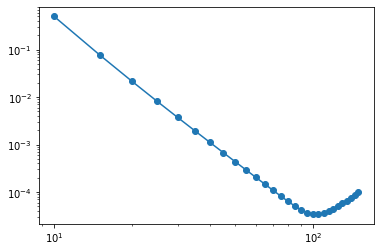

In [74]:
plt.plot(n_grids, errors, marker="o")
plt.xscale('log')
plt.yscale('log')

In [ ]:
### Next Step: Try Numpy + scipy.BFGS (Eric's jac trickscipy) ###

In [70]:
start_id = 0
end_id = 5
(np.log(errors[end_id])-np.log(errors[start_id]))/(np.log(n_grids[end_id]-1)-np.log(n_grids[start_id]-1))

-4.175093831490056